In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! mkdir ~/.kaggle
! cp drive/MyDrive//kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

train_dir = os.path.abspath(os.getcwd()) + "/chest_xray/train/"
test_dir = os.path.abspath(os.getcwd()) + "/chest_xray/test/"

print(train_dir)
print(tf.__version__)

/content/chest_xray/train/
2.6.0


In [ ]:
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, subset="training", seed=543, validation_split=0.2, labels='inferred')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, subset="validation", seed=543, validation_split=0.2, labels='inferred')
print('-----')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir)
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,labels='inferred')
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,labels='inferred')
print(train_ds.class_names)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
-----
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


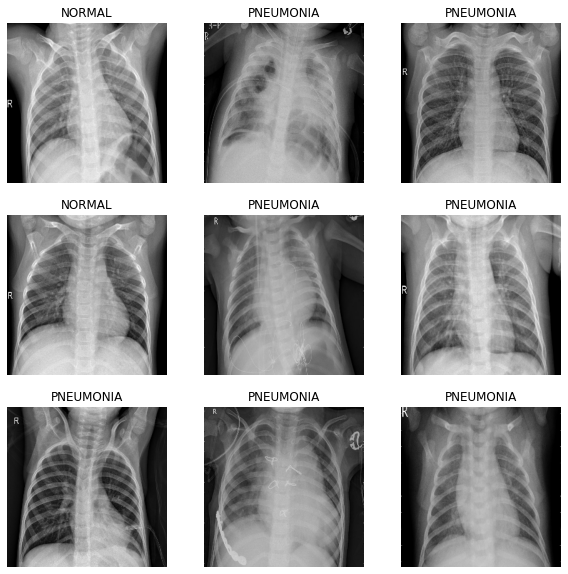

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

## A look at dimensions

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print(image_batch[0])

(32, 256, 256, 3)
(32,)
tf.Tensor(
[[[150.21484  150.21484  150.21484 ]
  [147.50781  147.50781  147.50781 ]
  [151.46094  151.46094  151.46094 ]
  ...
  [ 28.902344  28.902344  28.902344]
  [ 27.46875   27.46875   27.46875 ]
  [ 25.136719  25.136719  25.136719]]

 [[148.22266  148.22266  148.22266 ]
  [139.08984  139.08984  139.08984 ]
  [136.91016  136.91016  136.91016 ]
  ...
  [ 30.625     30.625     30.625   ]
  [ 29.292969  29.292969  29.292969]
  [ 26.78125   26.78125   26.78125 ]]

 [[140.34766  140.34766  140.34766 ]
  [129.83203  129.83203  129.83203 ]
  [110.40625  110.40625  110.40625 ]
  ...
  [ 32.375     32.375     32.375   ]
  [ 31.175781  31.175781  31.175781]
  [ 29.        29.        29.      ]]

 ...

 [[ 11.        11.        11.      ]
  [ 11.        11.        11.      ]
  [ 11.        11.        11.      ]
  ...
  [ 11.21875   11.21875   11.21875 ]
  [ 12.        12.        12.      ]
  [ 12.        12.        12.      ]]

 [[ 11.        11.        11.      ]
  

According to the documentation (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory#returns), 3 channels (last dimension of image_batch tensor) corresponds to color channels RGB. Needs standardization to go from RGB to grayscale.

In [ ]:
# taken from tensorflow docs to show new range of color channel of this dataset
# https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data

standardization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

standardized_ds = train_ds.map(lambda x, y: (standardization_layer(x), y))
image_batch, labels_batch = next(iter(standardized_ds))
first_image = image_batch[0]
print(image_batch[0])

tf.Tensor(
[[[0.11567383 0.11567383 0.11567383]
  [0.11407017 0.11407017 0.11407017]
  [0.11700775 0.11700775 0.11700775]
  ...
  [0.08208487 0.08208487 0.08208487]
  [0.07058824 0.07058824 0.07058824]
  [0.06666667 0.06666667 0.06666667]]

 [[0.11705083 0.11705083 0.11705083]
  [0.10874335 0.10874335 0.10874335]
  [0.12293199 0.12293199 0.12293199]
  ...
  [0.08909769 0.08909769 0.08909769]
  [0.0795178  0.0795178  0.0795178 ]
  [0.06482843 0.06482843 0.06482843]]

 [[0.09891238 0.09891238 0.09891238]
  [0.11962461 0.11962461 0.11962461]
  [0.12870209 0.12870209 0.12870209]
  ...
  [0.10293089 0.10293089 0.10293089]
  [0.09104627 0.09104627 0.09104627]
  [0.06090686 0.06090686 0.06090686]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0

## Model #1

In [ ]:
num_classes = 2
model = Sequential(
    [
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu') ,
    layers.MaxPooling2D(),
    layers.Dense(128) ,
    layers.Flatten(),
    layers.Dense(num_classes) ,
    ]
)

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.build(input_shape=image_batch.shape)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (32, 256, 256, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (32, 128, 128, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (32, 128, 128, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (32, 64, 64, 64)          0         
_________________________________________________________________
dense_17 (Dense)             (32, 64, 64, 128)         8320      
_________________________________________________________________
flatten_14 (Flatten)         (32, 524288)              0         
_________________________________________________________________
dense_18 (Dense)             (32, 2)                 

### Training Model #1

In [ ]:
epochs=5
history = model.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
131/131 [==============================] - 444s 3s/step - loss: 158.4173 - accuracy: 0.8620 - val_loss: 2.1129 - val_accuracy: 0.9655
Epoch 2/5
131/131 [==============================] - 438s 3s/step - loss: 2.8993 - accuracy: 0.9480 - val_loss: 1.3017 - val_accuracy: 0.9636
Epoch 3/5
131/131 [==============================] - 440s 3s/step - loss: 0.6245 - accuracy: 0.9753 - val_loss: 0.4762 - val_accuracy: 0.9808
Epoch 4/5
131/131 [==============================] - 438s 3s/step - loss: 0.3795 - accuracy: 0.9803 - val_loss: 0.2383 - val_accuracy: 0.9875
Epoch 5/5
131/131 [==============================] - 441s 3s/step - loss: 0.1305 - accuracy: 0.9911 - val_loss: 0.8140 - val_accuracy: 0.9770


In [ ]:
history.history

{'accuracy': [0.8619698286056519,
  0.9479990601539612,
  0.9753175377845764,
  0.9803498387336731,
  0.991133451461792],
 'loss': [158.4173126220703,
  2.899315118789673,
  0.624459981918335,
  0.3795463442802429,
  0.13046206533908844],
 'val_accuracy': [0.9654842019081116,
  0.9635666608810425,
  0.9808245301246643,
  0.9875359535217285,
  0.9769894480705261],
 'val_loss': [2.1128973960876465,
  1.3016630411148071,
  0.4762185215950012,
  0.2382999062538147,
  0.8139564990997314]}

### Test data with Model #1

In [ ]:
results = model.predict(test_ds)
for result in results:
  score = tf.nn.softmax(result)
  print(test_ds.class_names[np.argmax(score)], 100 * np.max(score))

PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
PNEUMONIA 84.43174362182617
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
NORMAL 100.0
NORMAL 100.0
NORMAL 100.0
PNEUMONIA 100.0
NORMAL 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
NORMAL 100.0
NORMAL 100.0
NORMAL 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
NORMAL 99.8051404953003
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 99.99998807907104
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
PNEUMONIA 100.0
NORMAL 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
PNEUMONIA 100.0
NORMAL 99.99823570251465
PNEUMONIA 100.0
PNEUMONIA 100.0
NORMAL 100.0
NORMAL 100.0
PNEUMONIA 99.99366998672485
PNEUMONIA 100.0
PNEUMONIA